# Graph Convolutional Neural Network for Chemistry
### Sample code:  
is life worth living by iwatobipen  
https://iwatobipen.wordpress.com/2019/04/05/make-graph-convolution-model-with-geometric-deep-learning-extension-library-for-pytorch-rdkit-chemoinformatics-pytorch/  
### Sample data:
Solubility dataset of RDkit

In [1]:
import numpy as np
from rdkit import Chem
import torch
from torch_geometric.data import Data
import numpy as np

RDKit WARNING: [16:29:49] Enabling RDKit 2019.09.3 jupyter extensions


# Graph-structured data of chemistry

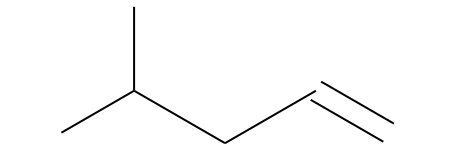

In [2]:
mols = [mol for mol in Chem.SDMolSupplier('./solubility_rdkit/solubility.train.sdf')]
mol = mols[15]
atoms = mol.GetAtoms()
atom = atoms[0]
mol

原子種

In [3]:
[atom.GetSymbol() for atom in atoms]

['C', 'C', 'C', 'C', 'C', 'C']

結合隣接原子数

In [4]:
[atom.GetDegree() for atom in atoms]

[1, 3, 1, 2, 2, 1]

水素数

In [5]:
[atom.GetTotalNumHs() for atom in atoms]

[3, 1, 3, 2, 1, 2]

その原子に予想される接続の最大数

In [6]:
[atom.GetImplicitValence() for atom in atoms]

[3, 1, 3, 2, 1, 2]

型式電価

In [7]:
[atom.GetFormalCharge() for atom in atoms]

[0, 0, 0, 0, 0, 0]

ラジカル電価数

In [8]:
[atom.GetNumRadicalElectrons() for atom in atoms]

[0, 0, 0, 0, 0, 0]

混成軌道

In [9]:
[atom.GetHybridization() for atom in atoms]

[rdkit.Chem.rdchem.HybridizationType.SP3,
 rdkit.Chem.rdchem.HybridizationType.SP3,
 rdkit.Chem.rdchem.HybridizationType.SP3,
 rdkit.Chem.rdchem.HybridizationType.SP3,
 rdkit.Chem.rdchem.HybridizationType.SP2,
 rdkit.Chem.rdchem.HybridizationType.SP2]

# mol2graphの動作確認

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import torch
from torch_geometric.data import Data
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

import torch.nn.functional as F
from torch.nn import ModuleList, Linear, BatchNorm1d
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.data import DataLoader
from torch_scatter import scatter_mean

import mol2graph

RDKit WARNING: [15:39:27] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('The code uses GPU!')
else:
    device = torch.device('cpu')
    print('The code uses CPU...')

The code uses CPU...


In [3]:
mols = np.array([mol for mol in Chem.SDMolSupplier('./solubility_rdkit/solubility.train.sdf')])
proparties = np.array([mol.GetProp('SOL') for mol in mols], dtype=float)

kf = KFold(n_splits=5, random_state=1640, shuffle=True)
train_idx, test_idx = list(kf.split(mols, np.zeros(len(mols))))[0]

train_X = [mol2graph.mol2vec(m) for m in mols[train_idx].tolist()]
train_y = proparties[train_idx]
for i, data in enumerate(train_X):
    data.y = torch.FloatTensor([train_y[i]]).to(device)

test_X = [mol2graph.mol2vec(m) for m in mols[test_idx].tolist()]
test_y = proparties[test_idx]
for i, data in enumerate(test_X):
    data.y = torch.FloatTensor([test_y[i]]).to(device)

train_loader = DataLoader(train_X, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_X, batch_size=64, shuffle=True, drop_last=True)

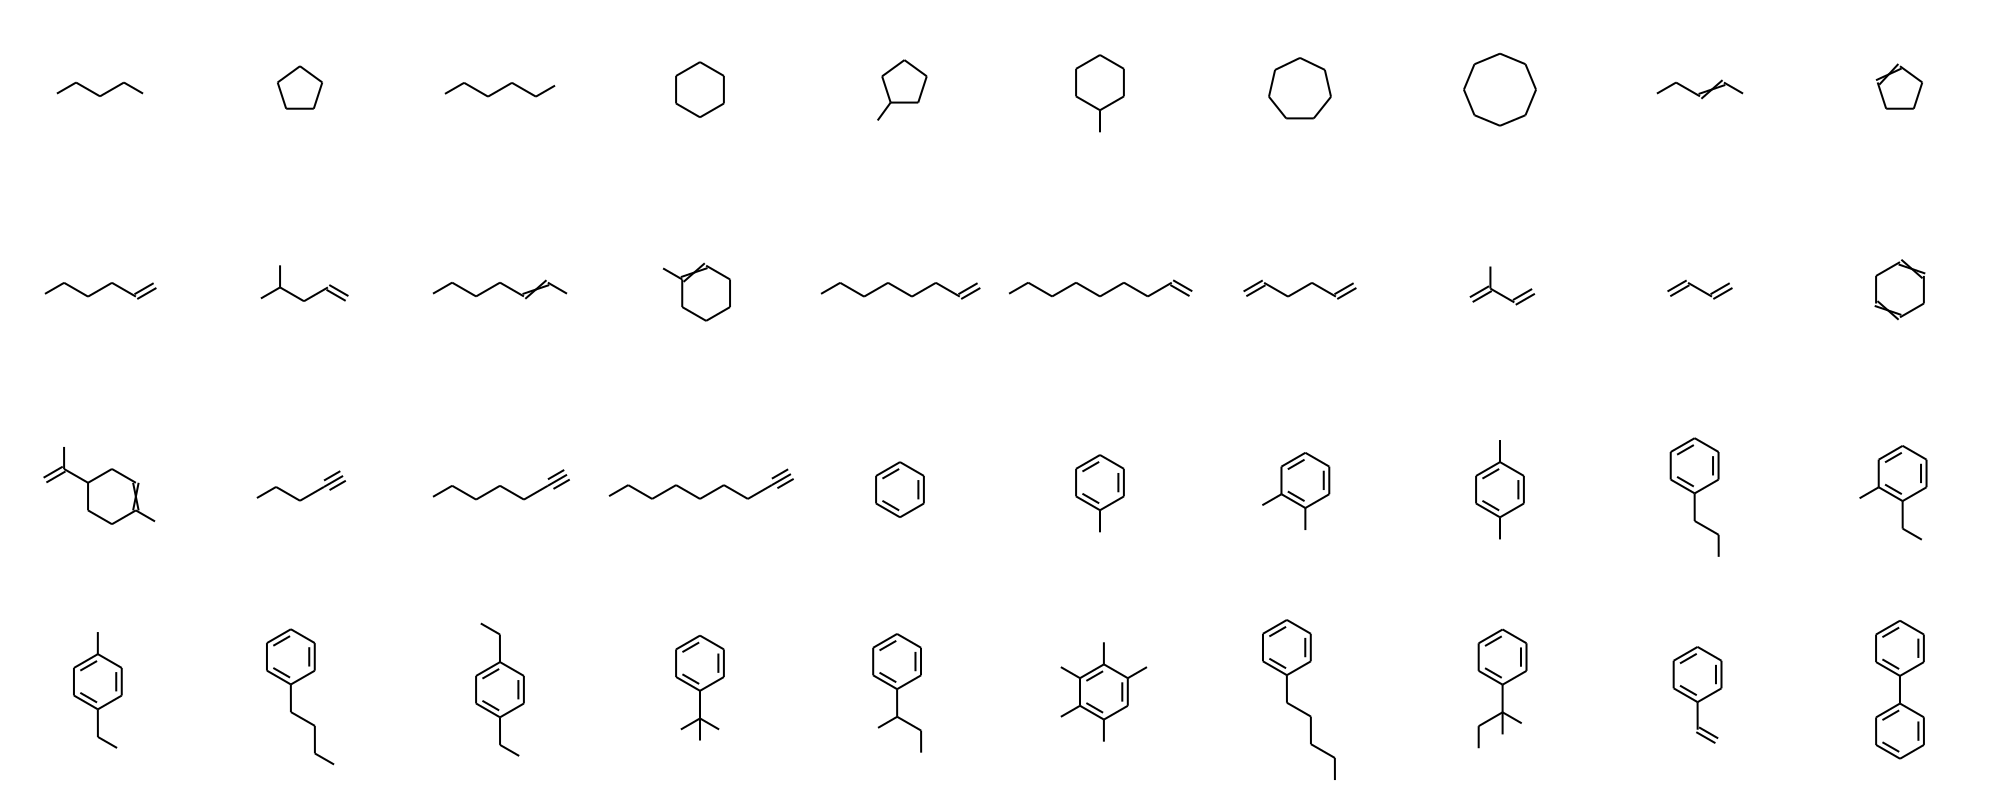

In [4]:
Draw.MolsToGridImage(mols[train_idx].tolist()[:40], molsPerRow=10)

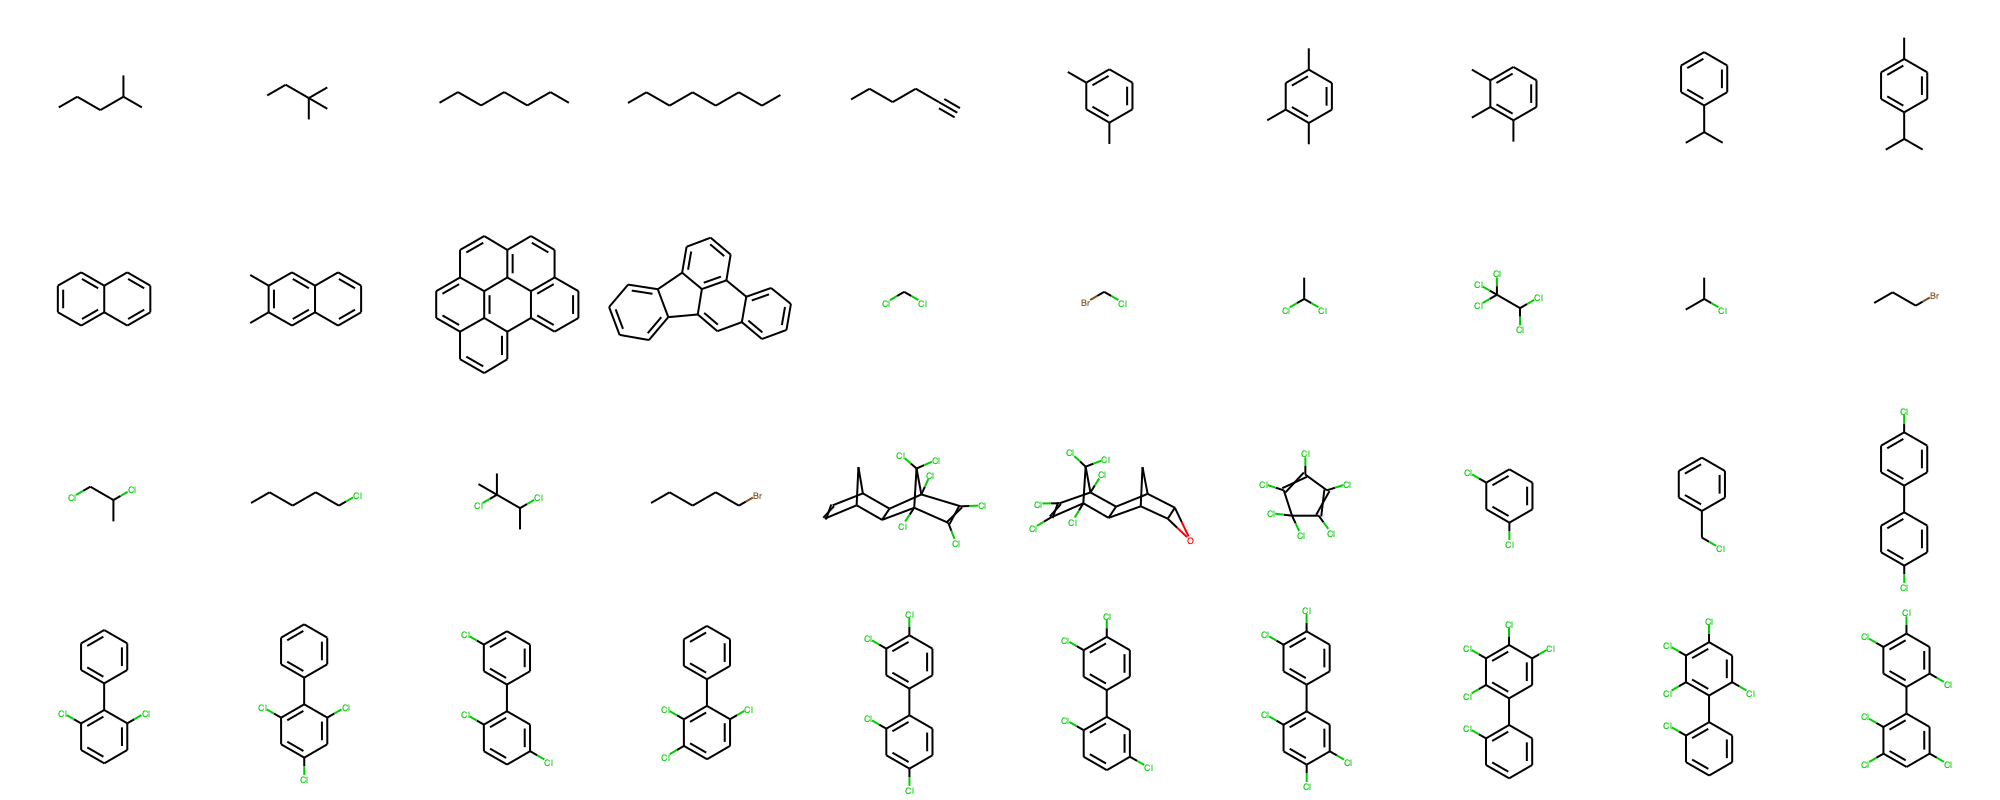

In [5]:
Draw.MolsToGridImage(mols[test_idx].tolist()[:40], molsPerRow=10)

In [6]:
class MolecularGCN(torch.nn.Module):
    def __init__(self):
        super(MolecularGCN, self).__init__()
        self.n_features = 75
        self.n_conv_hidden = 3
        self.n_mlp_hidden = 3
        self.dim = 64
        self.graphconv1 = GCNConv(self.n_features, self.dim)
        self.bn1 = BatchNorm1d(self.dim)
        self.graphconv_hidden = ModuleList(
            [GCNConv(self.dim, self.dim, cached=False) for _ in range(self.n_conv_hidden)]
        )
        self.bn_conv = ModuleList(
            [BatchNorm1d(self.dim) for _ in range(self.n_conv_hidden)]
        )
        self.mlp_hidden =  ModuleList(
            [Linear(self.dim, self.dim) for _ in range(self.n_mlp_hidden)]
        )
        self.bn_mlp = ModuleList(
            [BatchNorm1d(self.dim) for _ in range(self.n_mlp_hidden)]
        )
        self.mlp_out = Linear(self.dim,1)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.graphconv1(x, edge_index))
        x = self.bn1(x)
        for graphconv, bn_conv in zip(self.graphconv_hidden, self.bn_conv):
            x = graphconv(x, edge_index)
            x = bn_conv(x)
        x = global_add_pool(x, data.batch)
        for fc_mlp, bn_mlp in zip(self.mlp_hidden, self.bn_mlp):
            x = F.relu(fc_mlp(x))
            x = bn_mlp(x)
            x = F.dropout(x, p=0.1, training=self.training)
        x = self.mlp_out(x)
        return x 

In [35]:
model = MolecularGCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data.y.unsqueeze(1))
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_X)

def test(loader):
    model.eval()
    P, T, R2 = [], [], []
    for data in loader:
        data = data.to(device)
        y_pred = model(data)
        P.append(y_pred.detach().numpy())
        T.append(data.y.detach().numpy())
        R2.append(r2_score(y_pred.detach().numpy(), data.y.detach().numpy()))    
    return  np.concatenate(T), np.concatenate(P), np.mean(R2)

hist = {
    "mae":[],
    "r2":[],
    "test_r2":[],
    'y_true_train':[],
    'y_pred_train':[],
    'y_true_test':[],
    'y_pred_test':[],
}

for epoch in range(1, 200):
    train_mse = train(epoch)
    y_train, y_train_pred, train_r2 = test(train_loader)
    y_test, y_test_pred, test_r2 = test(test_loader)
    hist["mae"].append(train_mse)
    hist["r2"].append(train_r2)
    hist["test_r2"].append(test_r2)
    hist['y_true_train'].append(y_train)
    hist['y_pred_train'].append(y_train_pred)
    hist['y_true_test'].append(y_test)
    hist['y_pred_test'].append(y_test_pred)
    print(f'Epoch: {epoch}, Train MAE: {train_mse:.3}, Train_R2: {train_r2:.3}, Test_R2: {test_r2:.3}')

Epoch: 1, Train MAE: 8.36, Train_R2: -8.22e+02, Test_R2: -9.87e+02
Epoch: 2, Train MAE: 7.31, Train_R2: -74.0, Test_R2: -71.6
Epoch: 3, Train MAE: 6.68, Train_R2: -10.2, Test_R2: -11.4
Epoch: 4, Train MAE: 6.31, Train_R2: -3.17, Test_R2: -3.35
Epoch: 5, Train MAE: 5.79, Train_R2: -1.93, Test_R2: -1.68
Epoch: 6, Train MAE: 5.63, Train_R2: -0.652, Test_R2: -0.411
Epoch: 7, Train MAE: 4.92, Train_R2: -0.894, Test_R2: -0.527
Epoch: 8, Train MAE: 4.56, Train_R2: -0.599, Test_R2: -0.445
Epoch: 9, Train MAE: 4.1, Train_R2: -0.204, Test_R2: -0.067
Epoch: 10, Train MAE: 3.67, Train_R2: -0.199, Test_R2: 0.0872
Epoch: 11, Train MAE: 3.09, Train_R2: 0.0936, Test_R2: 0.115
Epoch: 12, Train MAE: 2.51, Train_R2: 0.381, Test_R2: 0.476
Epoch: 13, Train MAE: 2.18, Train_R2: 0.525, Test_R2: 0.549
Epoch: 14, Train MAE: 1.79, Train_R2: 0.705, Test_R2: 0.687
Epoch: 15, Train MAE: 1.42, Train_R2: 0.604, Test_R2: 0.649
Epoch: 16, Train MAE: 1.28, Train_R2: 0.687, Test_R2: 0.667
Epoch: 17, Train MAE: 1.18, Tra

Epoch: 136, Train MAE: 0.389, Train_R2: 0.957, Test_R2: 0.895
Epoch: 137, Train MAE: 0.316, Train_R2: 0.963, Test_R2: 0.902
Epoch: 138, Train MAE: 0.388, Train_R2: 0.97, Test_R2: 0.899
Epoch: 139, Train MAE: 0.356, Train_R2: 0.964, Test_R2: 0.895
Epoch: 140, Train MAE: 0.404, Train_R2: 0.954, Test_R2: 0.888
Epoch: 141, Train MAE: 0.35, Train_R2: 0.933, Test_R2: 0.849
Epoch: 142, Train MAE: 0.332, Train_R2: 0.96, Test_R2: 0.888
Epoch: 143, Train MAE: 0.34, Train_R2: 0.957, Test_R2: 0.894
Epoch: 144, Train MAE: 0.425, Train_R2: 0.953, Test_R2: 0.897
Epoch: 145, Train MAE: 0.383, Train_R2: 0.956, Test_R2: 0.879
Epoch: 146, Train MAE: 0.343, Train_R2: 0.961, Test_R2: 0.879
Epoch: 147, Train MAE: 0.321, Train_R2: 0.961, Test_R2: 0.884
Epoch: 148, Train MAE: 0.301, Train_R2: 0.969, Test_R2: 0.889
Epoch: 149, Train MAE: 0.344, Train_R2: 0.954, Test_R2: 0.883
Epoch: 150, Train MAE: 0.307, Train_R2: 0.962, Test_R2: 0.874
Epoch: 151, Train MAE: 0.316, Train_R2: 0.958, Test_R2: 0.88
Epoch: 152, T

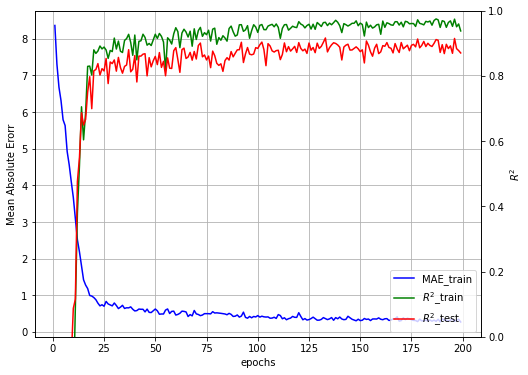

In [58]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
epochs = np.arange(1,200)
ax1.plot(epochs, hist['mae'], label="MAE_train", c='blue')
ax2.plot(epochs, hist['r2'], label=r"$R^2$_train", c='green')
ax2.plot(epochs, hist['test_r2'], label=r"$R^2$_test", c='red')
ax1.set_xlabel('epochs')
ax1.set_ylabel(r'Mean Absolute Erorr')
ax1.grid(True)
ax2.set_ylabel(r'$R^2$')
ax2.set_ylim([0,1])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right')
plt.show()

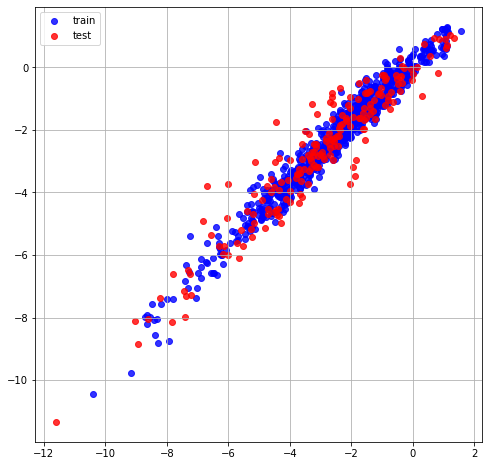

In [54]:
plt.figure(figsize=(8,8))
plt.grid(True)
plt.scatter(hist['y_true_train'][-1], hist['y_pred_train'][-1], color='blue', alpha=0.8, label='train')
plt.scatter(hist['y_true_test'][-1], hist['y_pred_test'][-1], color='red', alpha=0.8, label='test')
plt.legend()